In [1]:
# Step-1: import libraries 


import warnings
warnings.filterwarnings('ignore')

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score




In [2]:
# Step-2: Dataset Path

for dirname,_,filenames in os.walk('/kaggle/input'):
    for file in filenames:
        print(os.path.join(dirname,file))

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [3]:
# Step-3: Load Dataset

path='/kaggle/input/sms-spam-collection-dataset/spam.csv'

df=pd.read_csv(path,encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
# Step-4: Preprocessing 

df=df[['v1','v2']]
df.columns=['label','text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# convert label to Numeric
df['label']=df['label'].map({'ham':0,'spam':1})
label=['ham','spam']


In [6]:
# Step-5: Train Test Split

x=df['text']
y=df['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)

In [7]:
# Step-6: TF-IDF with n-grams

vectorizer=TfidfVectorizer(stop_words='english',lowercase=True,ngram_range=(1,2),max_features=5000)
x_train_tfidf=vectorizer.fit_transform(x_train)
x_test_tfidf=vectorizer.transform(x_test)


In [8]:
# Step-7: Logistic Regression - Hyperparameter Tuning


log_params={
    'C':[0.01,0.1,1,5],
    'penalty':['l1','l2'],
    'solver':['liblinear','saga']
}

log_reg=LogisticRegression(max_iter=2000)
log_grid=GridSearchCV(log_reg,log_params,cv=5,scoring='f1',n_jobs=-1)
log_grid.fit(x_train_tfidf,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 5], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

Logistic Regression Best Params:  {'C': 5, 'penalty': 'l2', 'solver': 'saga'}
Accuracy Score: 97.85%
Classification Report: 
               precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.98      0.85      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



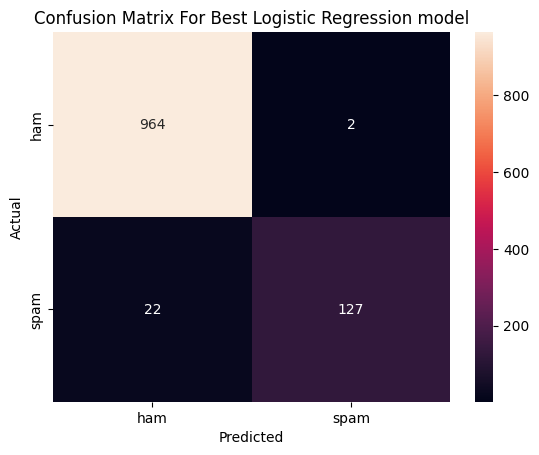

In [25]:
# Best model

best_log=log_grid.best_estimator_
log_pred=best_log.predict(x_test_tfidf)

best_log_param=log_grid.best_params_

acc_log=accuracy_score(y_test,log_pred)

print("Logistic Regression Best Params: ",log_grid.best_params_)
print(f"Accuracy Score: {acc_log*100:.2f}%")
print('Classification Report: \n',classification_report(y_test,log_pred,target_names=label))
log_cm=confusion_matrix(y_test,log_pred)
sns.heatmap(log_cm,annot=True,fmt='d',xticklabels=label,yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix For Best Logistic Regression model')
plt.show()

In [11]:
# Step-8: SVM Hyperparameter Tuning

svm_params={
    'C':[0.1,1,10],
    'kernel':['linear','rbf'],
    'gamma':['scale',0.01,0.1,1]
}
svm_reg=SVC()

svm_grid=GridSearchCV(svm_reg,svm_params,cv=5,scoring='f1',n_jobs=-1)
svm_grid.fit(x_train_tfidf,y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             scoring='f1')

Accuracy Score: 98.30%
Classification Report : 
                precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



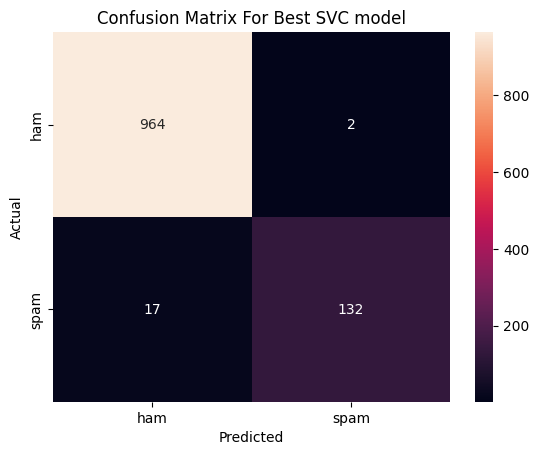

In [27]:
#svm_pred=svm_grid.predict(x_test_tfidf)
#print(accuracy_score(y_test,svm_pred))

best_svm=svm_grid.best_estimator_
svm_pred1=best_svm.predict(x_test_tfidf)

best_svm_param=svm_grid.best_params_

acc_svm=accuracy_score(y_test,svm_pred2)

print(f'Accuracy Score: {acc_svm*100:.2f}%')
print(f"Classification Report : \n ",classification_report(y_test,svm_pred1,target_names=label))

svm_cm=confusion_matrix(y_test,svm_pred)
sns.heatmap(svm_cm,annot=True,fmt='d',xticklabels=label,yticklabels=label)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix For Best SVC model')
plt.show()

In [32]:
# Step-9: Result Table

results=pd.DataFrame({
    'Model':['Logistic Regression','SVM'],
    'Best Params':[best_log_param,best_svm_param],
    'Accuracy':[f'{acc_log*100:.2f}%',f'{acc_svm*100:.2f}%']
})

results

,Model,Best Params,Accuracy
0,Logistic Regression,"{'C': 5, 'penalty': 'l2', 'solver': 'saga'}",97.85%
1,SVM,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",98.30%
